In [1]:
%load_ext autoreload
%autoreload 2
# %matplotlib widget

In [75]:
import xarray as xr
import numpy as np
import pandas as pd

import ecephys_analyses as ea 

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

In [76]:
xr.set_options(keep_attrs=True)

In [125]:
experiment = "sleep-homeostasis"
nrem = ["N1", "N2"]
light_period_start = "09:00:00"
light_period_end = "21:00:00"
            
def get_abs_sink(spws):
    _spws = spws.copy()
    _spws['sink_amplitude'] = spws['sink_amplitude'].abs()
    _spws['sink_integral'] = spws['sink_amplitude'].abs()
    return _spws

def load_baseline_light_period_nrem(subject, abs_sink=False):
    condition = "light-period-circadian-match"
    hyp = ea.load_hypnogram(subject, experiment, condition)
    hyp = hyp.keep_states(nrem).keep_between(light_period_start, light_period_end)
    spws = ea.load_spws(subject, experiment, condition)
    spws = spws[hyp.covers_time(spws.start_time)]
    if abs_sink:
        spws = get_abs_sink(spws)
    return hyp, spws


def load_early_recovery_nrem(subject, abs_sink=False):
    condition = "recovery-sleep"
    duration = "01:00:00"
    hyp = ea.load_hypnogram(subject, experiment, condition)
    hyp = hyp.keep_states(nrem).keep_first(duration)
    spws = ea.load_spws(subject, experiment, condition)
    spws = spws[hyp.covers_time(spws.start_time)]
    if abs_sink:
        spws = get_abs_sink(spws)
    return hyp, spws

def load_late_recovery_nrem(subject, abs_sink=False):
    condition = "recovery-sleep"
    duration = "01:00:00"
    hyp = ea.load_hypnogram(subject, experiment, condition)
    hyp = hyp.keep_states(nrem).keep_last(duration)
    spws = ea.load_spws(subject, experiment, condition)
    spws = spws[hyp.covers_time(spws.start_time)]
    if abs_sink:
        spws = get_abs_sink(spws)
    return hyp, spws


def load_first2h_recovery_nrem(subject, abs_sink=False):
    condition = "recovery-sleep"
    duration = "02:00:00"
    hyp = ea.load_hypnogram(subject, experiment, condition)
    hyp = hyp.keep_states(nrem).keep_first(duration)
    spws = ea.load_spws(subject, experiment, condition)
    spws = spws[hyp.covers_time(spws.start_time)]
    if abs_sink:
        spws = get_abs_sink(spws)
    return hyp, spws


def load_first2h_recovery_match_nrem(subject, rec_hyp, abs_sink=False):
    condition = "recovery-sleep-circadian-match"
    duration = "02:00:00"
    hyp = ea.load_hypnogram(subject, experiment, condition)
    hyp = (
        hyp.keep_states(nrem)
        .keep_between(rec_hyp.start_time.min().strftime("%H:%M:%S"), light_period_end)
        .keep_first(duration)
    )
    spws = ea.load_spws(subject, experiment, condition)
    spws = spws[hyp.covers_time(spws.start_time)]
    if abs_sink:
        spws = get_abs_sink(spws)
    return hyp, spws

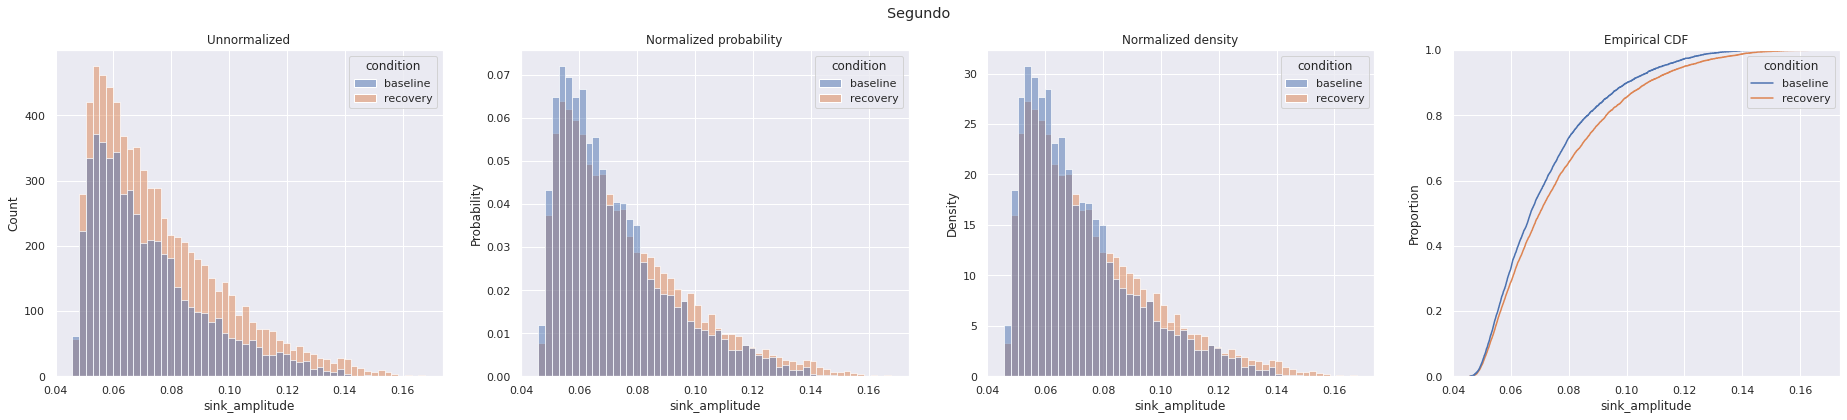

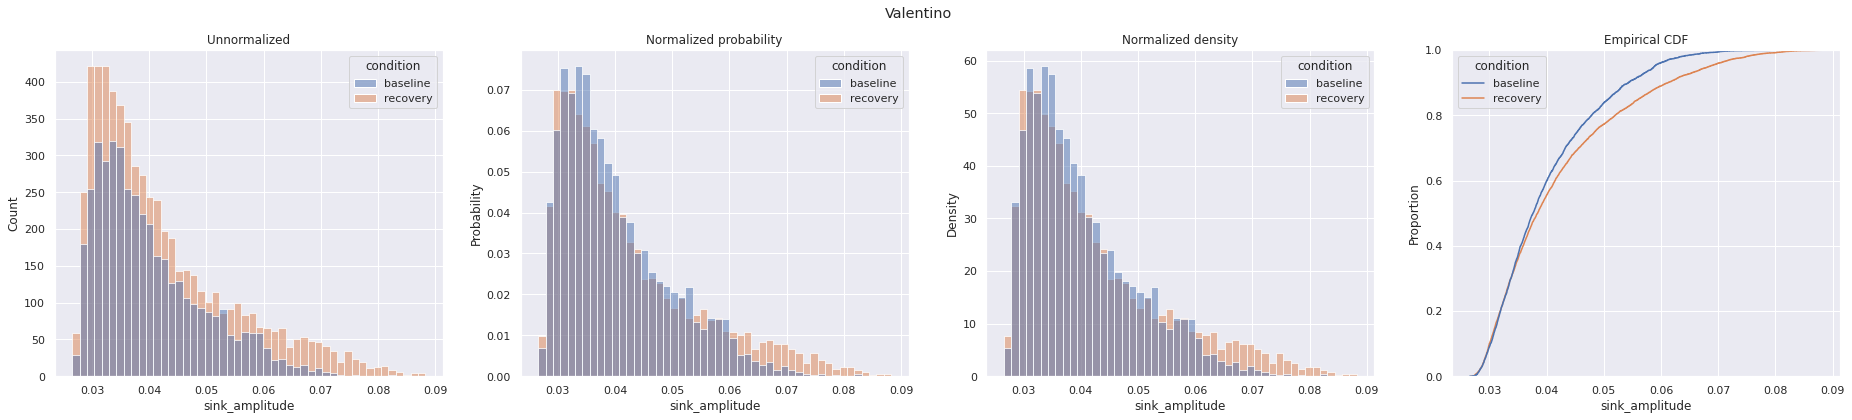

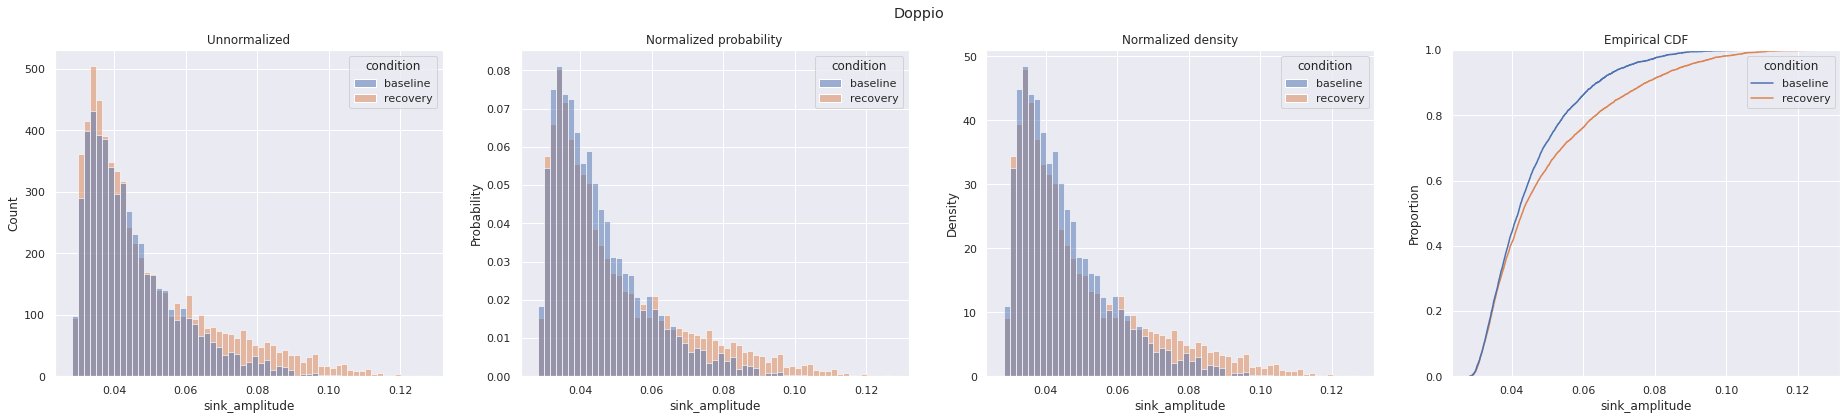

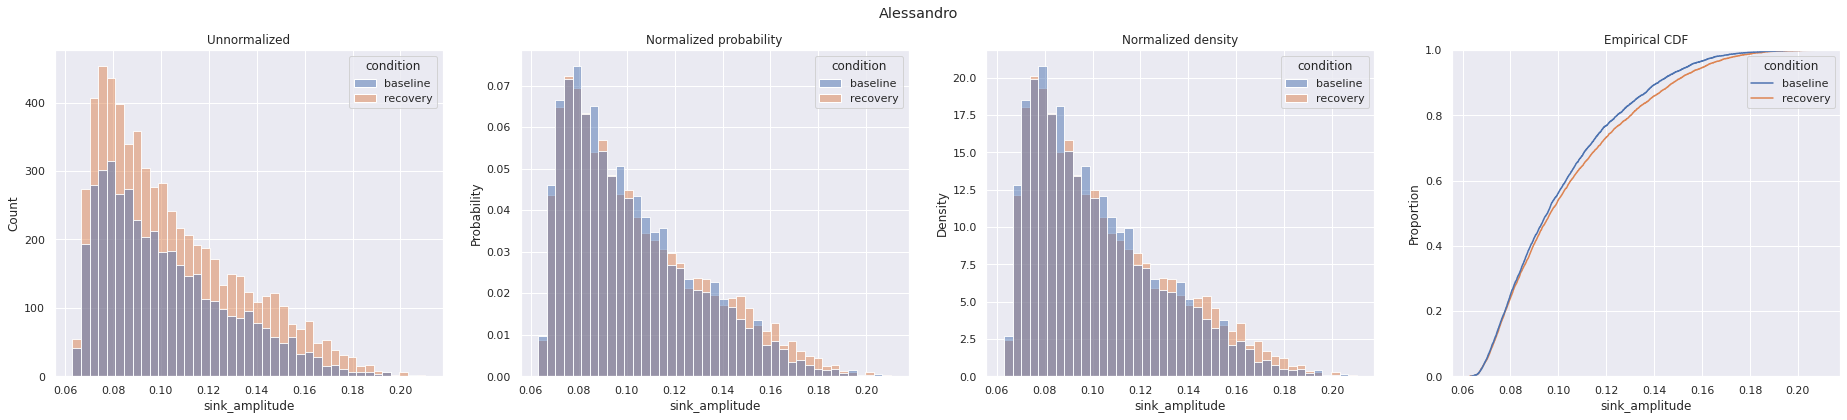

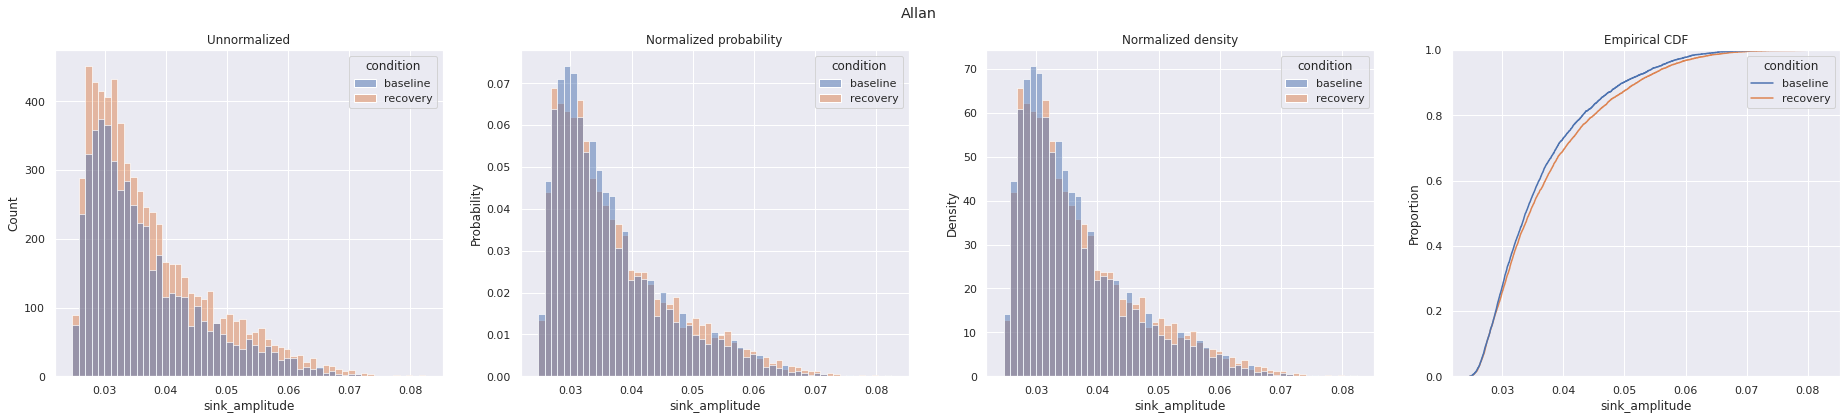

In [167]:
subjects = ["Segundo", "Valentino", "Doppio", "Alessandro", "Allan"]
col = 'sink_amplitude'
log_transform = False

for subject in subjects:
    rec_hyp, rec_spws = load_first2h_recovery_nrem(subject, abs_sink=True)
    bsl_hyp, bsl_spws = load_first2h_recovery_match_nrem(subject, rec_hyp, abs_sink=True)
    
    df = pd.concat([bsl_spws[col], rec_spws[col]], keys=['baseline', 'recovery'], names=['condition']).reset_index().drop(columns='spw_number')
    if log_transform:
        df[col] = np.log10(df[col])
        
    fig, axes = plt.subplots(1, 4, figsize=(32, 6))
    fig.suptitle(subject)
    sns.histplot(df, x=col, hue='condition', ax=axes[0])
    axes[0].set(title='Unnormalized')
    sns.histplot(df, x=col, hue='condition', stat='probability', common_norm=False, ax=axes[1])
    axes[1].set(title='Normalized probability')
    sns.histplot(df, x=col, hue='condition', stat='density', common_norm=False, ax=axes[2])
    axes[2].set(title='Normalized density')
    sns.ecdfplot(df, x=col, hue='condition', ax=axes[3])
    axes[3].set(title='Empirical CDF')